###imports

In [1]:
import zipfile
import os
import shutil
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
                                     BatchNormalization, Activation, LSTM, Embedding)
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###Extracting Dataset

In [3]:
def extract_dataset() :
  zip_path = '/content/Teeth DataSet.zip'
  extract_path = ''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


In [4]:
extract_dataset()

In [5]:
train_ds_path = "/content/Teeth_Dataset/Training"
test_ds_path='/content/Teeth_Dataset/Testing'
val_ds_path='/content/Teeth_Dataset/Validation'

###Remove test incorrect files

In [6]:
for dirpath, dirnames, filenames in os.walk(test_ds_path):
  for dir in dirnames :
    if dir in ["output","outputs","out"] :
      shutil.rmtree(os.path.join(test_ds_path,dir))

os.remove(os.path.join(test_ds_path,'output_image.jpg'))

###Load DataSet

In [7]:


batch_size = 128
img_size = (128, 128)
train = tf.keras.utils.image_dataset_from_directory(
    train_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)
val = tf.keras.utils.image_dataset_from_directory(
    val_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)
test = tf.keras.utils.image_dataset_from_directory(
    test_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


### Visualization one Batch

Images batch shape: (128, 128, 128, 3)
Labels batch shape: (128,)


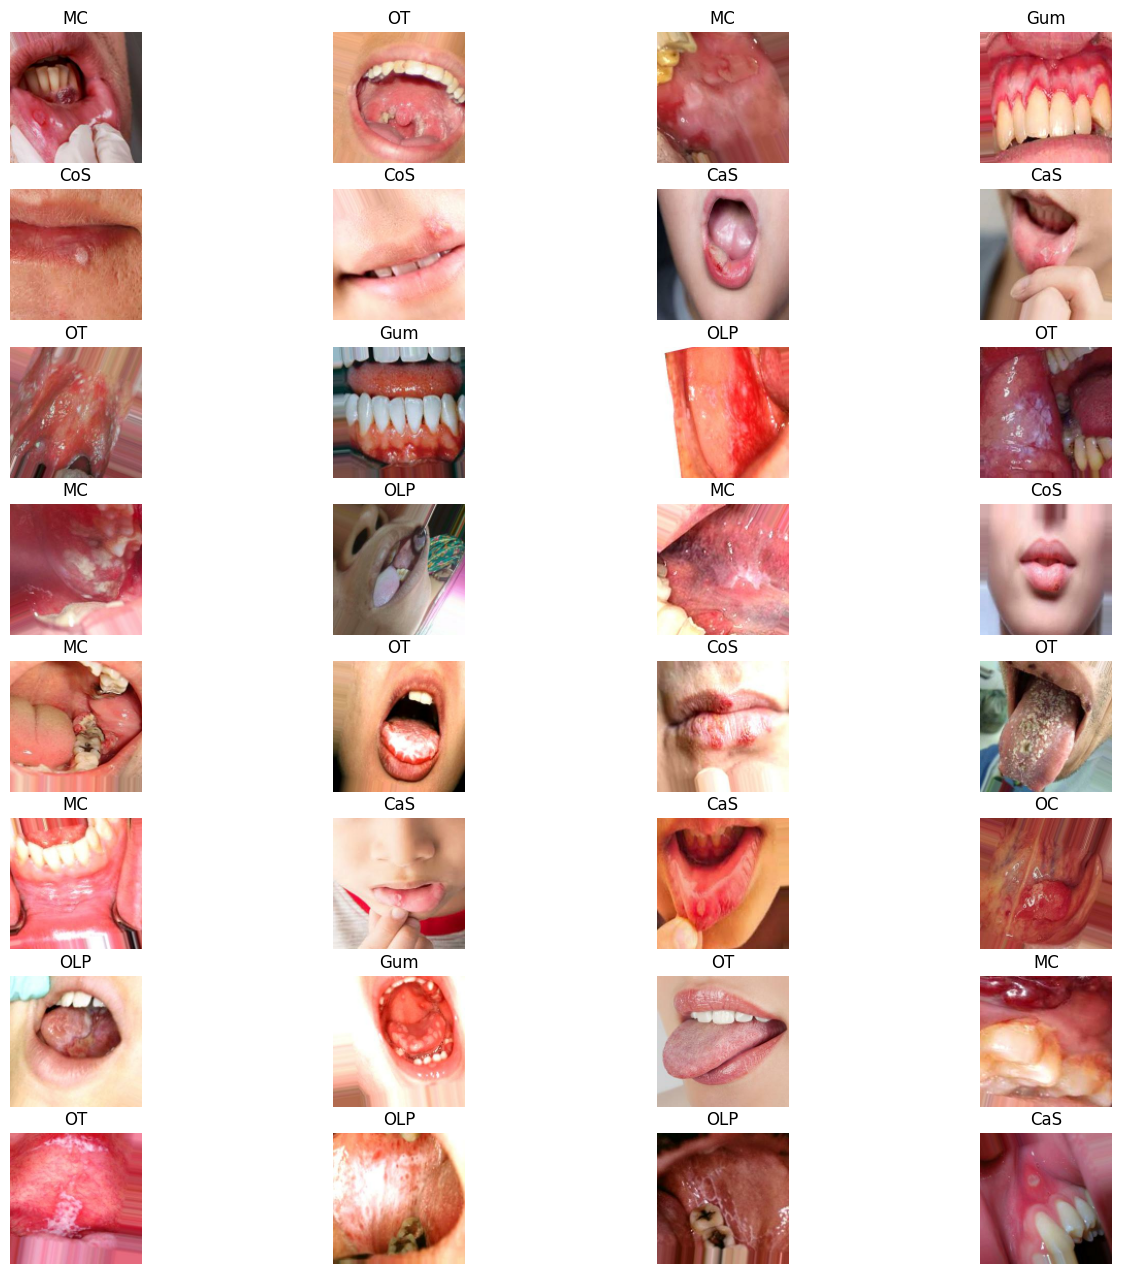

In [8]:
for images, labels in train.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    plt.figure(figsize=(16, 16))
    for index in range(32) :
      ax = plt.subplot(8, 4, index+1)
      plt.imshow(images[index].numpy().astype("uint8"))
      plt.title(train.class_names[labels[index]])
      plt.axis("off")
    plt.show()

###Preprocessing

In [9]:
normalization = tf.keras.layers.Rescaling(1./255)

train = train.map(lambda x, y: (normalization(x), y))
val = val.map(lambda x, y: (normalization(x), y))
test = test.map(lambda x, y: (normalization(x), y))

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1),
])

In [11]:
train_after_augmentation = train.map(lambda x, y: (data_augmentation(x,training=True), y))

###Visualization

In [12]:
distribute_classes=dict()
for dirpath, dirnames, filenames in os.walk(train_ds_path):
  for dir in dirnames :
    fulldir = os.path.join(train_ds_path,dir)
    distribute_classes[dir]= len(os.listdir(fulldir))
print(distribute_classes)

{'Gum': 360, 'MC': 540, 'OT': 393, 'CoS': 450, 'OC': 324, 'OLP': 540, 'CaS': 480}


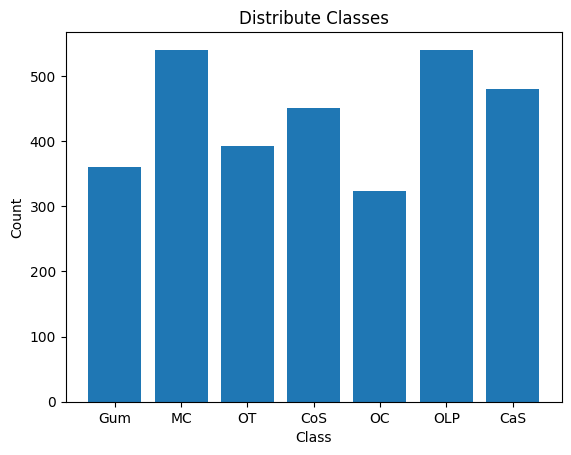

In [13]:
plt.bar(distribute_classes.keys(),distribute_classes.values())
plt.title("Distribute Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

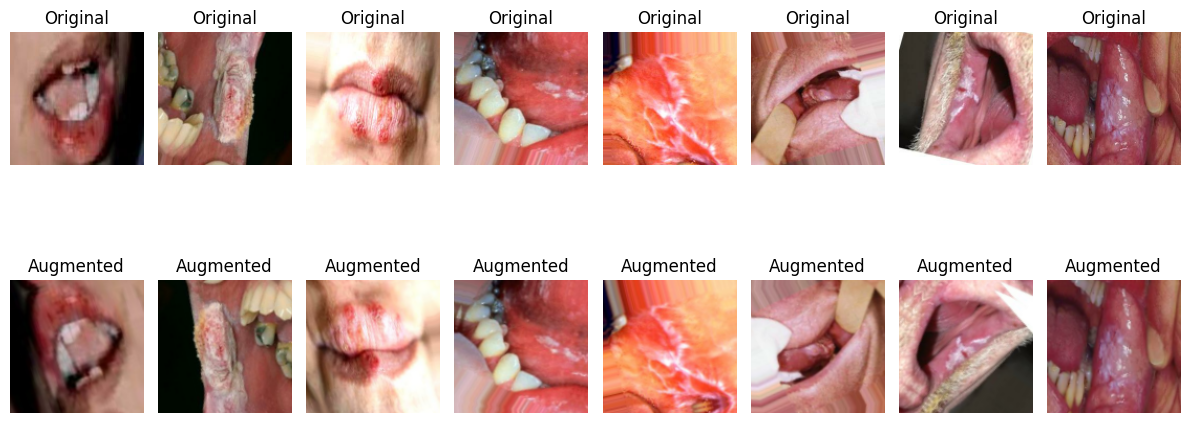

In [14]:
for images, labels in train.take(1):
    plt.figure(figsize=(12, 6))

    for i in range(8):
        ax = plt.subplot(2, 8, i + 1)
        img = images[i]
        plt.imshow(tf.cast((img*255), tf.uint8))
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, 8, i + 1 + 8)
        aug_img = data_augmentation(tf.expand_dims(img, 0))
        plt.imshow(tf.cast((aug_img[0]*255), tf.uint8))
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


#Model

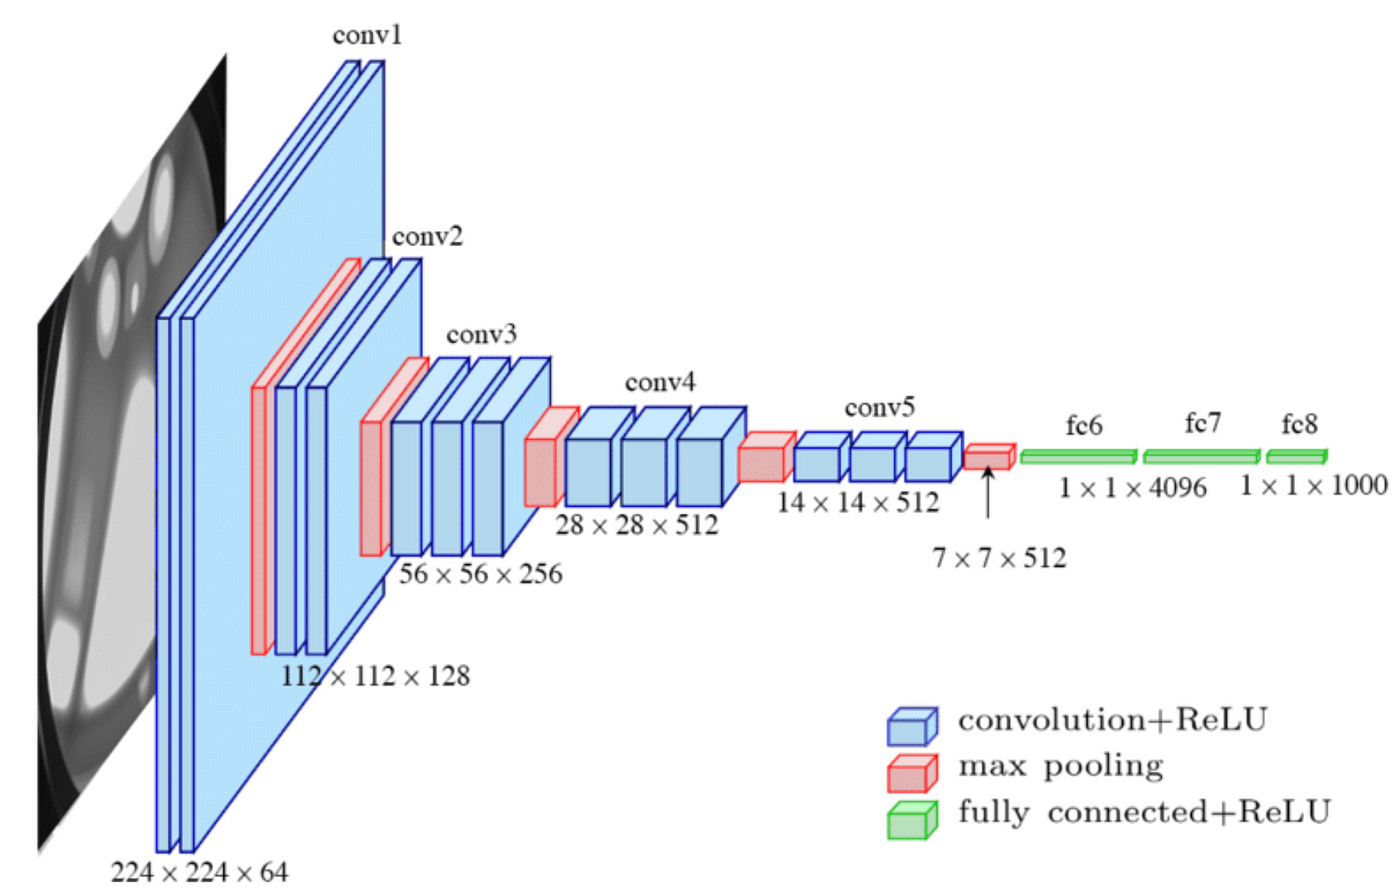

In [59]:
model = Sequential([
    Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='leaky_relu',padding='same', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='leaky_relu', padding='same',kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='leaky_relu', kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(512, activation='leaky_relu', kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(7, activation='softmax')
])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,457,287 (17.00 MB)

 Trainable params: 4,457,287 (17.00 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
early_stopping= tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1
)

In [62]:
history=model.fit(train_after_augmentation, epochs=150,validation_data=val ,callbacks=[early_stopping],verbose=1)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 880ms/step - accuracy: 0.1451 - loss: 8.3713 - val_accuracy: 0.1770 - val_loss: 6.7885
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 732ms/step - accuracy: 0.1786 - loss: 6.7192 - val_accuracy: 0.2296 - val_loss: 6.4059
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 661ms/step - accuracy: 0.2556 - loss: 6.2886 - val_accuracy: 0.2986 - val_loss: 5.9155
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.3137 - loss: 5.8837 - val_accuracy: 0.3580 - val_loss: 5.5929
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 671ms/step - accuracy: 0.3508 - loss: 5.4963 - val_accuracy: 0.3706 - val_loss: 5.3115
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - accuracy: 0.3635 - loss: 5.2422 - val_accuracy: 0.4066 - val_loss: 4.9319
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 672ms/step - accuracy: 0.4201 - loss: 4.8729 - val_accuracy: 0.5000 - val_loss: 4.5554
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 636ms/step - accuracy: 0.4773 - loss: 4.5126 - 

In [63]:
loss, acc = model.evaluate(test, verbose=1)
print('Accuracy: {:5.2f}%'.format(100 * acc))
print('Loss: {:5.2f}'.format(loss))


1028/1028 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8737 - loss: 1.5526
Accuracy: 87.65%
Loss:  1.55
